# census-2021

In [1]:
# PACKAGES
import pandas as pd
from janitor import clean_names
import altair as alt
import requests

In [3]:
# DATA
url = 'https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationandhouseholdestimatesenglandandwalescensus2021/census2021/census2021firstresultsenglandwales1.xlsx'
filename = '../data/external/census2021firstresultsenglandwales1.xlsx'

In [ ]:
# FETCH
r = requests.get(url)
open(filename, 'wb').write(r.content)
df = pd.read_excel(filename)

In [5]:
# P01 Census 2021: Usual resident population by sex, local authorities in England and Wales
P01 = pd.read_excel(filename,
sheet_name="P01", header=6)

<AxesSubplot:xlabel='All persons'>

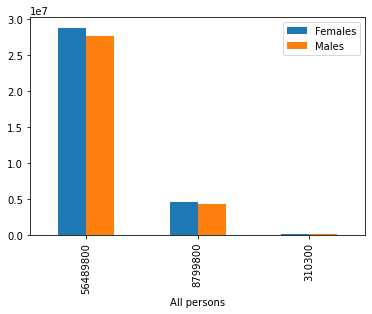

In [13]:
P01[P01['Area name'].isin(['Tower Hamlets', 'England', 'London'])].plot.bar(x='All persons')

In [15]:
# P02 Census 2021: Usual resident population by five-year age group, local authorities in England and Wales
P02 = pd.read_excel(filename,
sheet_name="P02", header=7)

<AxesSubplot:>

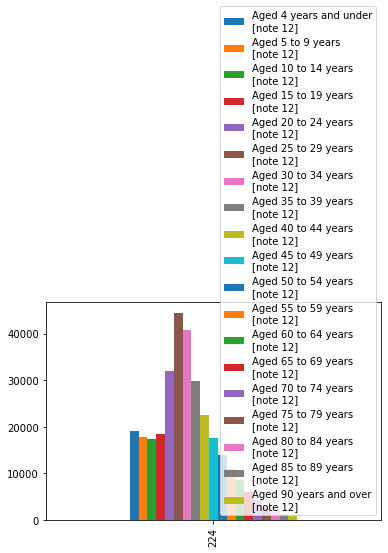

In [26]:
P02[P02['Area name'].isin(['Tower Hamlets'])][['Aged 4 years and under\n[note 12]', 'Aged 5 to 9 years\n[note 12]','Aged 10 to 14 years\n[note 12]', 'Aged 15 to 19 years\n[note 12]','Aged 20 to 24 years\n[note 12]', 'Aged 25 to 29 years\n[note 12]','Aged 30 to 34 years\n[note 12]', 'Aged 35 to 39 years\n[note 12]','Aged 40 to 44 years\n[note 12]', 'Aged 45 to 49 years\n[note 12]','Aged 50 to 54 years\n[note 12]', 'Aged 55 to 59 years\n[note 12]','Aged 60 to 64 years\n[note 12]', 'Aged 65 to 69 years\n[note 12]','Aged 70 to 74 years\n[note 12]', 'Aged 75 to 79 years\n[note 12]','Aged 80 to 84 years\n[note 12]', 'Aged 85 to 89 years\n[note 12]','Aged 90 years and over\n[note 12]']].plot.bar()

In [27]:
# P03 Census 2021: Usual resident population by sex and five-year age group, local authorities in England and Wales
P03 = pd.read_excel(filename,
sheet_name="P03", header=7)

In [29]:
def reshape_gender_data(df):
    df.reset_index(drop=True, inplace=True)
    df = df.rename(columns=lambda x:x.replace('note 12',''))
    df = df.clean_names(remove_special=True)
    df = df.rename(columns=lambda x:x.replace('females_aged_',''))
    df = df.rename(columns=lambda x:x.replace('males_aged_',''))
    df = df.rename(columns=lambda x:x.replace('_years',''))
    df = df.rename(columns=lambda x:x.replace('_to_','-'))
    df = df.rename(columns=lambda x:x.replace('4_and_under','00-04'))
    df = df.rename(columns=lambda x:x.replace('_and_over','+'))
    df = df.rename(columns=lambda x:x.replace('5-9','05-09'))
    df = df.transpose()
    df.reset_index(inplace=True)
    df.columns = ['group','england and wales', 'london', 'Tower Hamlets']
    # df = df.iloc[::-1]
    return df

In [30]:
P03_females = reshape_gender_data(P03[P03['Area name'].isin(['Tower Hamlets', 'England', 'London'])].filter(regex=r"Females.*"))
P03_males = reshape_gender_data(P03[P03['Area name'].isin(['Tower Hamlets', 'England', 'London'])].filter(regex=r"Males.*"))

In [31]:
P03_females

,group,england and wales,london,Tower Hamlets
0,00-04,1501600,259300,9300
1,05-09,1634400,260100,8600
2,10-14,1664100,261700,8600
3,15-19,1568100,240300,9300
4,20-24,1701500,304400,16900
5,25-29,1897400,412200,22600
6,30-34,2044400,422400,20300
7,35-39,1953500,382700,15000
8,40-44,1826700,343200,10900
9,45-49,1825600,301200,7900


In [32]:
[[P03_females.head(), P03_males.head()]]

[[   group  england and wales  london  Tower Hamlets
  0  00-04            1501600  259300           9300
  1  05-09            1634400  260100           8600
  2  10-14            1664100  261700           8600
  3  15-19            1568100  240300           9300
  4  20-24            1701500  304400          16900,
     group  england and wales  london  Tower Hamlets
  0  00-04            1575400  269700           9800
  1  05-09            1714200  271400           9000
  2  10-14            1749000  273600           8800
  3  15-19            1650800  249100           9100
  4  20-24            1712900  284800          15100]]

In [45]:
def population_pyramid(females, males):

    females = alt.Chart(females).properties(width=250)
    males = alt.Chart(males).properties(width=250)

    left = (
        females.encode(
            y=alt.Y("group:O", axis=None),
            x=alt.X(
                "Tower Hamlets:Q",
                title="2021 population",
                sort=alt.SortOrder("descending"),
            ),
            tooltip=["Tower Hamlets"],
        )
        .mark_bar()
        .properties(title="Tower Hamlets females")
    )

    middle = (
        females.encode(
            y=alt.Y("group:O", axis=None),
            text=alt.Text("group:O"),
        )
        .mark_text()
        .properties(width=20)
    )

    right = (
        males.encode(
            y=alt.Y("group:O", axis=None),
            x=alt.X("Tower Hamlets:Q", title="2021 population"),
            tooltip=["Tower Hamlets"],
        )
        .mark_bar()
        .properties(title="Tower Hamlets males")
    )

    return alt.concat(left, middle, right, spacing=5)

####

In [46]:
population_pyramid(P03_females, P03_males)

alt.ConcatChart(...)

In [28]:
# P04 Census 2021: Usual resident population density, local authorities in England and Wales
P04 = pd.read_excel(filename,
sheet_name="P04", header=6)

In [29]:
P04[P04['Area name'].isin(['Tower Hamlets', 'England', 'London'])]

,Area code [note 2],Area name,Population density (number of usual residents per square kilometre) \n[note 13]
1,E92000001,England,434
211,E12000007,London,5598
224,E09000030,Tower Hamlets,15695


In [31]:
# H01 Census 2021: Number of households with at least one usual resident, local authorities in England and Wales
H01 = pd.read_excel(filename,
sheet_name="H01", header=6)

In [32]:
H01[H01['Area name'].isin(['Tower Hamlets', 'England', 'London'])]

,Area code [note 2],Area name,Number of households with at least one usual resident
1,E92000001,England,23435700
211,E12000007,London,3423800
224,E09000030,Tower Hamlets,120500
